In [130]:
import enum
import itertools
from enum import Enum
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import scipy.stats

from endfield_gacha_model import *
from plot_tools import *


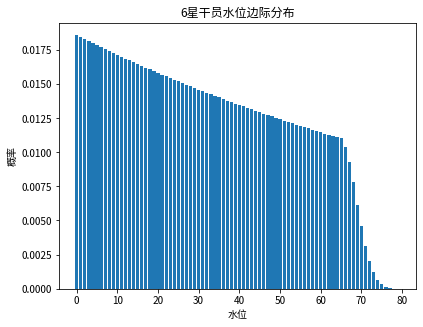

In [131]:
# 干员池综合概率


type 状态类 = 过渡态类


class 过渡态类(NamedTuple):
    水位_6星干员: int
    水位_5星干员: int


def 状态转移(起始状态: 状态类) -> list[tuple[状态类, float]]:
    转移概率列表: list[tuple[状态类, float]] = []

    六星概率 = operator_pity_6x[起始状态.水位_6星干员+1]
    五星概率 = operator_pity_5x[起始状态.水位_5星干员+1]
    五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
    四星概率 = 1 - 六星概率 - 五星概率

    # 抽到6星干员
    转移概率列表.append((过渡态类(水位_6星干员=0, 水位_5星干员=0), 六星概率))

    if 起始状态.水位_6星干员 < 79:
        # 抽到5星干员
        转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=0), 五星概率))

        if 起始状态.水位_5星干员 < 9:
            # 抽到4星干员
            转移概率列表.append((过渡态类(水位_6星干员=起始状态.水位_6星干员+1, 水位_5星干员=起始状态.水位_5星干员+1), 四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


状态列表 = []
状态列表.extend(过渡态类(水位_6星干员=i, 水位_5星干员=j) for i in range(80) for j in range(10))

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵[起始状态索引, 目标状态索引] += 概率
状态转移矩阵 = 状态转移矩阵.tocsr()

# 计算平稳分布
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(状态转移矩阵.T)
one_eigenvalue_index = np.argmin(np.abs(eigenvalues - 1))
stationary_distribution = np.abs(eigenvectors[:, one_eigenvalue_index])
assert np.allclose(stationary_distribution.imag, 0, atol=1e-10)
stationary_distribution = stationary_distribution.real
stationary_distribution /= stationary_distribution.sum()

六星干员水位边际分布 = np.zeros(80)

for 状态, 概率 in zip(状态列表, stationary_distribution):
    六星干员水位边际分布[状态.水位_6星干员] += 概率


plt.figure()
plt.bar(range(80), 六星干员水位边际分布)
plt.title("6星干员水位边际分布")
plt.xlabel("水位")
plt.ylabel("概率")
plt.show()


In [132]:
抽到n个6星的概率 = np.zeros(11)
for 六星数量 in range(1, 11):
    概率列表 = []
    for 初始六星水位 in range(80):
        六星水位概率 = 六星干员水位边际分布[初始六星水位]
        for 六星位置列表 in itertools.combinations(range(10), 六星数量):
            第一个六星位置 = 六星位置列表[0]
            抽第一个六星时的水位 = 初始六星水位 + 第一个六星位置
            if 抽第一个六星时的水位 >= 80:
                continue
            抽第一个六星时的六星概率 = operator_pity_6x[抽第一个六星时的水位+1]
            # print(抽第一个六星时的水位, 抽第一个六星时的六星概率)
            概率 = 1
            for i in range(10):
                if i < 第一个六星位置:
                    概率 *= 1 - operator_pity_6x[初始六星水位 + i + 1]
                elif i == 第一个六星位置:
                    概率 *= 抽第一个六星时的六星概率
                elif i in 六星位置列表:
                    概率 *= 0.008
                else:
                    概率 *= 1 - 0.008
            概率列表.append(六星水位概率 * 概率)
    抽到n个6星的概率[六星数量] = sum(概率列表)
    
抽到n个6星的概率[0] = 1 - 抽到n个6星的概率.sum()
抽到6星数量的期望 = (抽到n个6星的概率 * np.arange(11)).sum()

print(抽到n个6星的概率)
print(抽到6星数量的期望)
print(1/抽到n个6星的概率)


[8.21007356e-01 1.72592587e-01 6.26344064e-03 1.34697648e-04
 1.90097487e-06 1.83965310e-08 1.23632601e-10 5.69735489e-13
 1.72299039e-15 3.08779640e-18 2.49015839e-21]
0.18553125748596114
[1.21801588e+00 5.79399162e+00 1.59656658e+02 7.42403459e+03
 5.26045880e+05 5.43580742e+07 8.08848145e+09 1.75520047e+12
 5.80386290e+14 3.23855550e+17 4.01580882e+20]


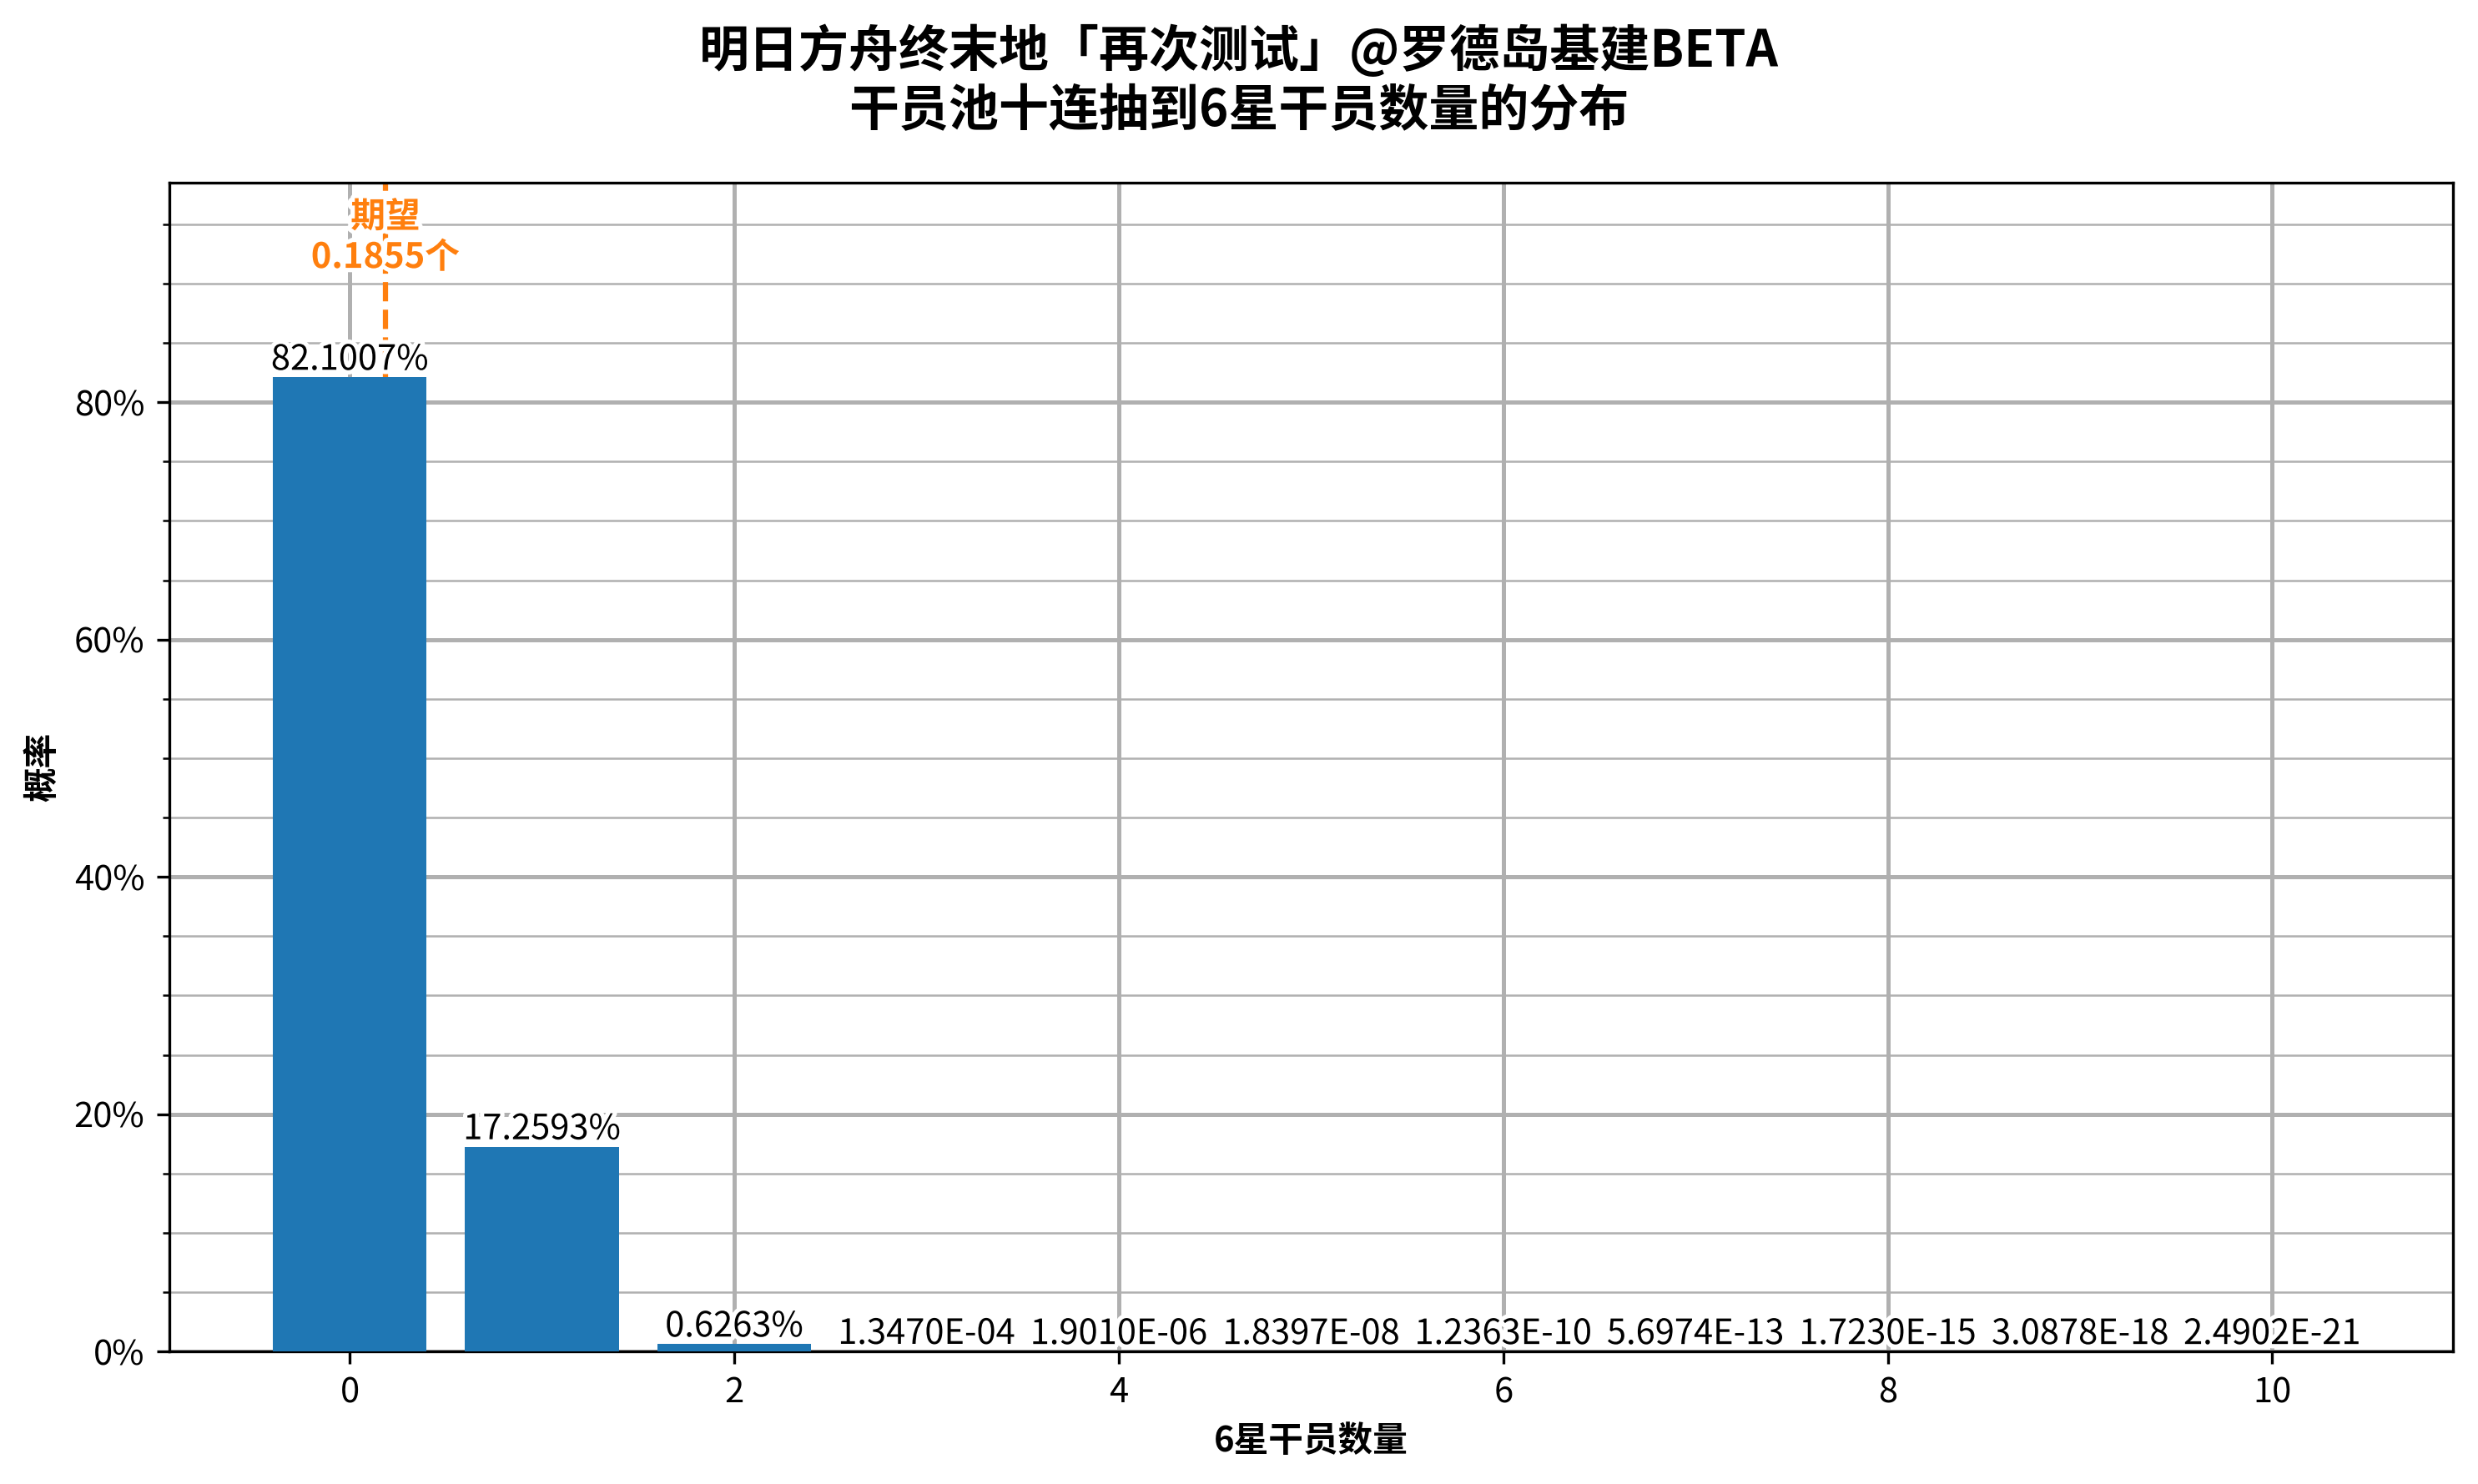

In [133]:
fig = plt.figure(figsize=(10, 6), layout="tight", dpi=300)
ax1 = fig.subplots(1, 1)

ax1.bar(range(11), 抽到n个6星的概率, zorder=10)
ax1_y_top = np.max(抽到n个6星的概率) * 1.2

# 图表标题、坐标轴标签
fig.suptitle(f"明日方舟终末地「再次测试」@罗德岛基建BETA\n干员池十连抽到6星干员数量的分布", fontweight="bold", fontsize="x-large")
# ax1.set_title("抽到UP6星干员时，获得的其他6星干员数量的边际分布", fontweight="bold")
ax1.set_ylabel("概率", fontweight="bold")
ax1.set_xlabel("6星干员数量", fontweight="bold")

# 显示概率具体数值
for i, p in enumerate(抽到n个6星的概率):
    ax1.annotate(f"{p:.4%}" if p>=1e-3 else f"{p:.4E}", (i, p), textcoords="offset points", xytext=(0, 0), ha="center", va="bottom", path_effects=stroke_white)

# 期望值
ax1.axvline(抽到6星数量的期望, color="C1", linestyle="--")
ax1.annotate(f"期望\n{抽到6星数量的期望:.4f}个", (抽到6星数量的期望, ax1_y_top),
             ha="center", va="top", xytext=(0, -5), textcoords="offset points",
             color="C1", fontweight="bold", path_effects=stroke_white)


# 显示网格
ax1.yaxis.minorticks_on()
ax1.grid(True, which="major", linewidth=1.2)
ax1.yaxis.grid(True, which="minor", linewidth=0.6)

# y 轴标签显示为百分比
ax1.yaxis.set_major_formatter(PercentFormatter(1))

ax1.set_ylim(0, ax1_y_top)

fig.savefig(f"图片/干员池十连抽到6星干员数量的分布.png", dpi=300)


In [134]:
# 武器池综合概率


type 状态类 = 过渡态类


class 过渡态类(NamedTuple):
    水位_6星武器: int
    水位_5星武器: int


def 状态转移(起始状态: 状态类) -> list[tuple[状态类, float]]:
    转移概率列表: list[tuple[状态类, float]] = []

    六星概率 = weapon_pity_6x[起始状态.水位_6星武器+1]
    五星概率 = weapon_pity_5x[起始状态.水位_5星武器+1]
    五星概率 = np.clip(五星概率, 0, 1 - 六星概率)
    四星概率 = 1 - 六星概率 - 五星概率

    # 抽到6星干员
    转移概率列表.append((过渡态类(水位_6星武器=0, 水位_5星武器=0), 六星概率))

    if 起始状态.水位_6星武器 < 39:
        # 抽到5星干员
        转移概率列表.append((过渡态类(水位_6星武器=起始状态.水位_6星武器+1, 水位_5星武器=0), 五星概率))

        if 起始状态.水位_5星武器 < 9:
            # 抽到4星干员
            转移概率列表.append((过渡态类(水位_6星武器=起始状态.水位_6星武器+1, 水位_5星武器=起始状态.水位_5星武器+1), 四星概率))

    assert np.isclose(sum(x[1] for x in 转移概率列表), 1)
    return 转移概率列表


状态列表 = []
状态列表.extend(过渡态类(水位_6星武器=i, 水位_5星武器=j) for i in range(40) for j in range(10))

状态数量 = len(状态列表)
状态索引 = {状态: i for i, 状态 in enumerate(状态列表)}

状态转移矩阵 = scipy.sparse.dok_array((状态数量, 状态数量))
for 起始状态 in 状态列表:
    起始状态索引 = 状态索引[起始状态]
    转移概率列表 = 状态转移(起始状态)
    for 目标状态, 概率 in 转移概率列表:
        目标状态索引 = 状态索引[目标状态]
        状态转移矩阵[起始状态索引, 目标状态索引] += 概率
状态转移矩阵 = 状态转移矩阵.tocsr()

# 计算平稳分布
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(状态转移矩阵.T)
one_eigenvalue_index = np.argmin(np.abs(eigenvalues - 1))
stationary_distribution = np.abs(eigenvectors[:, one_eigenvalue_index])
assert np.allclose(stationary_distribution.imag, 0, atol=1e-10)
stationary_distribution = stationary_distribution.real
stationary_distribution /= stationary_distribution.sum()

六星武器水位边际分布 = np.zeros(40)

for 状态, 概率 in zip(状态列表, stationary_distribution):
    六星武器水位边际分布[状态.水位_6星武器] += 概率


In [135]:
抽到n个6星的概率 = np.zeros(11)
for 六星数量 in range(1, 11):
    概率列表 = []
    for 初始六星水位 in range(40):
        六星水位概率 = 六星武器水位边际分布[初始六星水位]
        for 六星位置列表 in itertools.combinations(range(10), 六星数量):
            第一个六星位置 = 六星位置列表[0]
            抽第一个六星时的水位 = 初始六星水位 + 第一个六星位置
            if 抽第一个六星时的水位 >= 40:
                continue
            抽第一个六星时的六星概率 = weapon_pity_6x[抽第一个六星时的水位+1]
            # print(抽第一个六星时的水位, 抽第一个六星时的六星概率)
            概率 = 1
            for i in range(10):
                if i < 第一个六星位置:
                    概率 *= 1 - weapon_pity_6x[初始六星水位 + i + 1]
                elif i == 第一个六星位置:
                    概率 *= 抽第一个六星时的六星概率
                elif i in 六星位置列表:
                    概率 *= 0.04
                else:
                    概率 *= 1 - 0.04
            概率列表.append(六星水位概率 * 概率)
    抽到n个6星的概率[六星数量] = sum(概率列表)

抽到n个6星的概率[0] = 1 - 抽到n个6星的概率.sum()
抽到6星数量的期望 = (抽到n个6星的概率 * np.arange(11)).sum()

print(抽到n个6星的概率)
print(抽到6星数量的期望)
print(1/抽到n个6星的概率)


[5.83453561e-01 3.44272863e-01 6.45511617e-02 7.17235130e-03
 5.22983949e-04 2.61491975e-05 9.07958245e-07 2.16180535e-08
 3.37782085e-10 3.12761190e-12 1.30317163e-14]
0.49712052354394615
[1.71393246e+00 2.90467274e+00 1.54915880e+01 1.39424292e+02
 1.91210457e+03 3.82420914e+04 1.10137223e+06 4.62576338e+07
 2.96048856e+09 3.19732765e+11 7.67358635e+13]


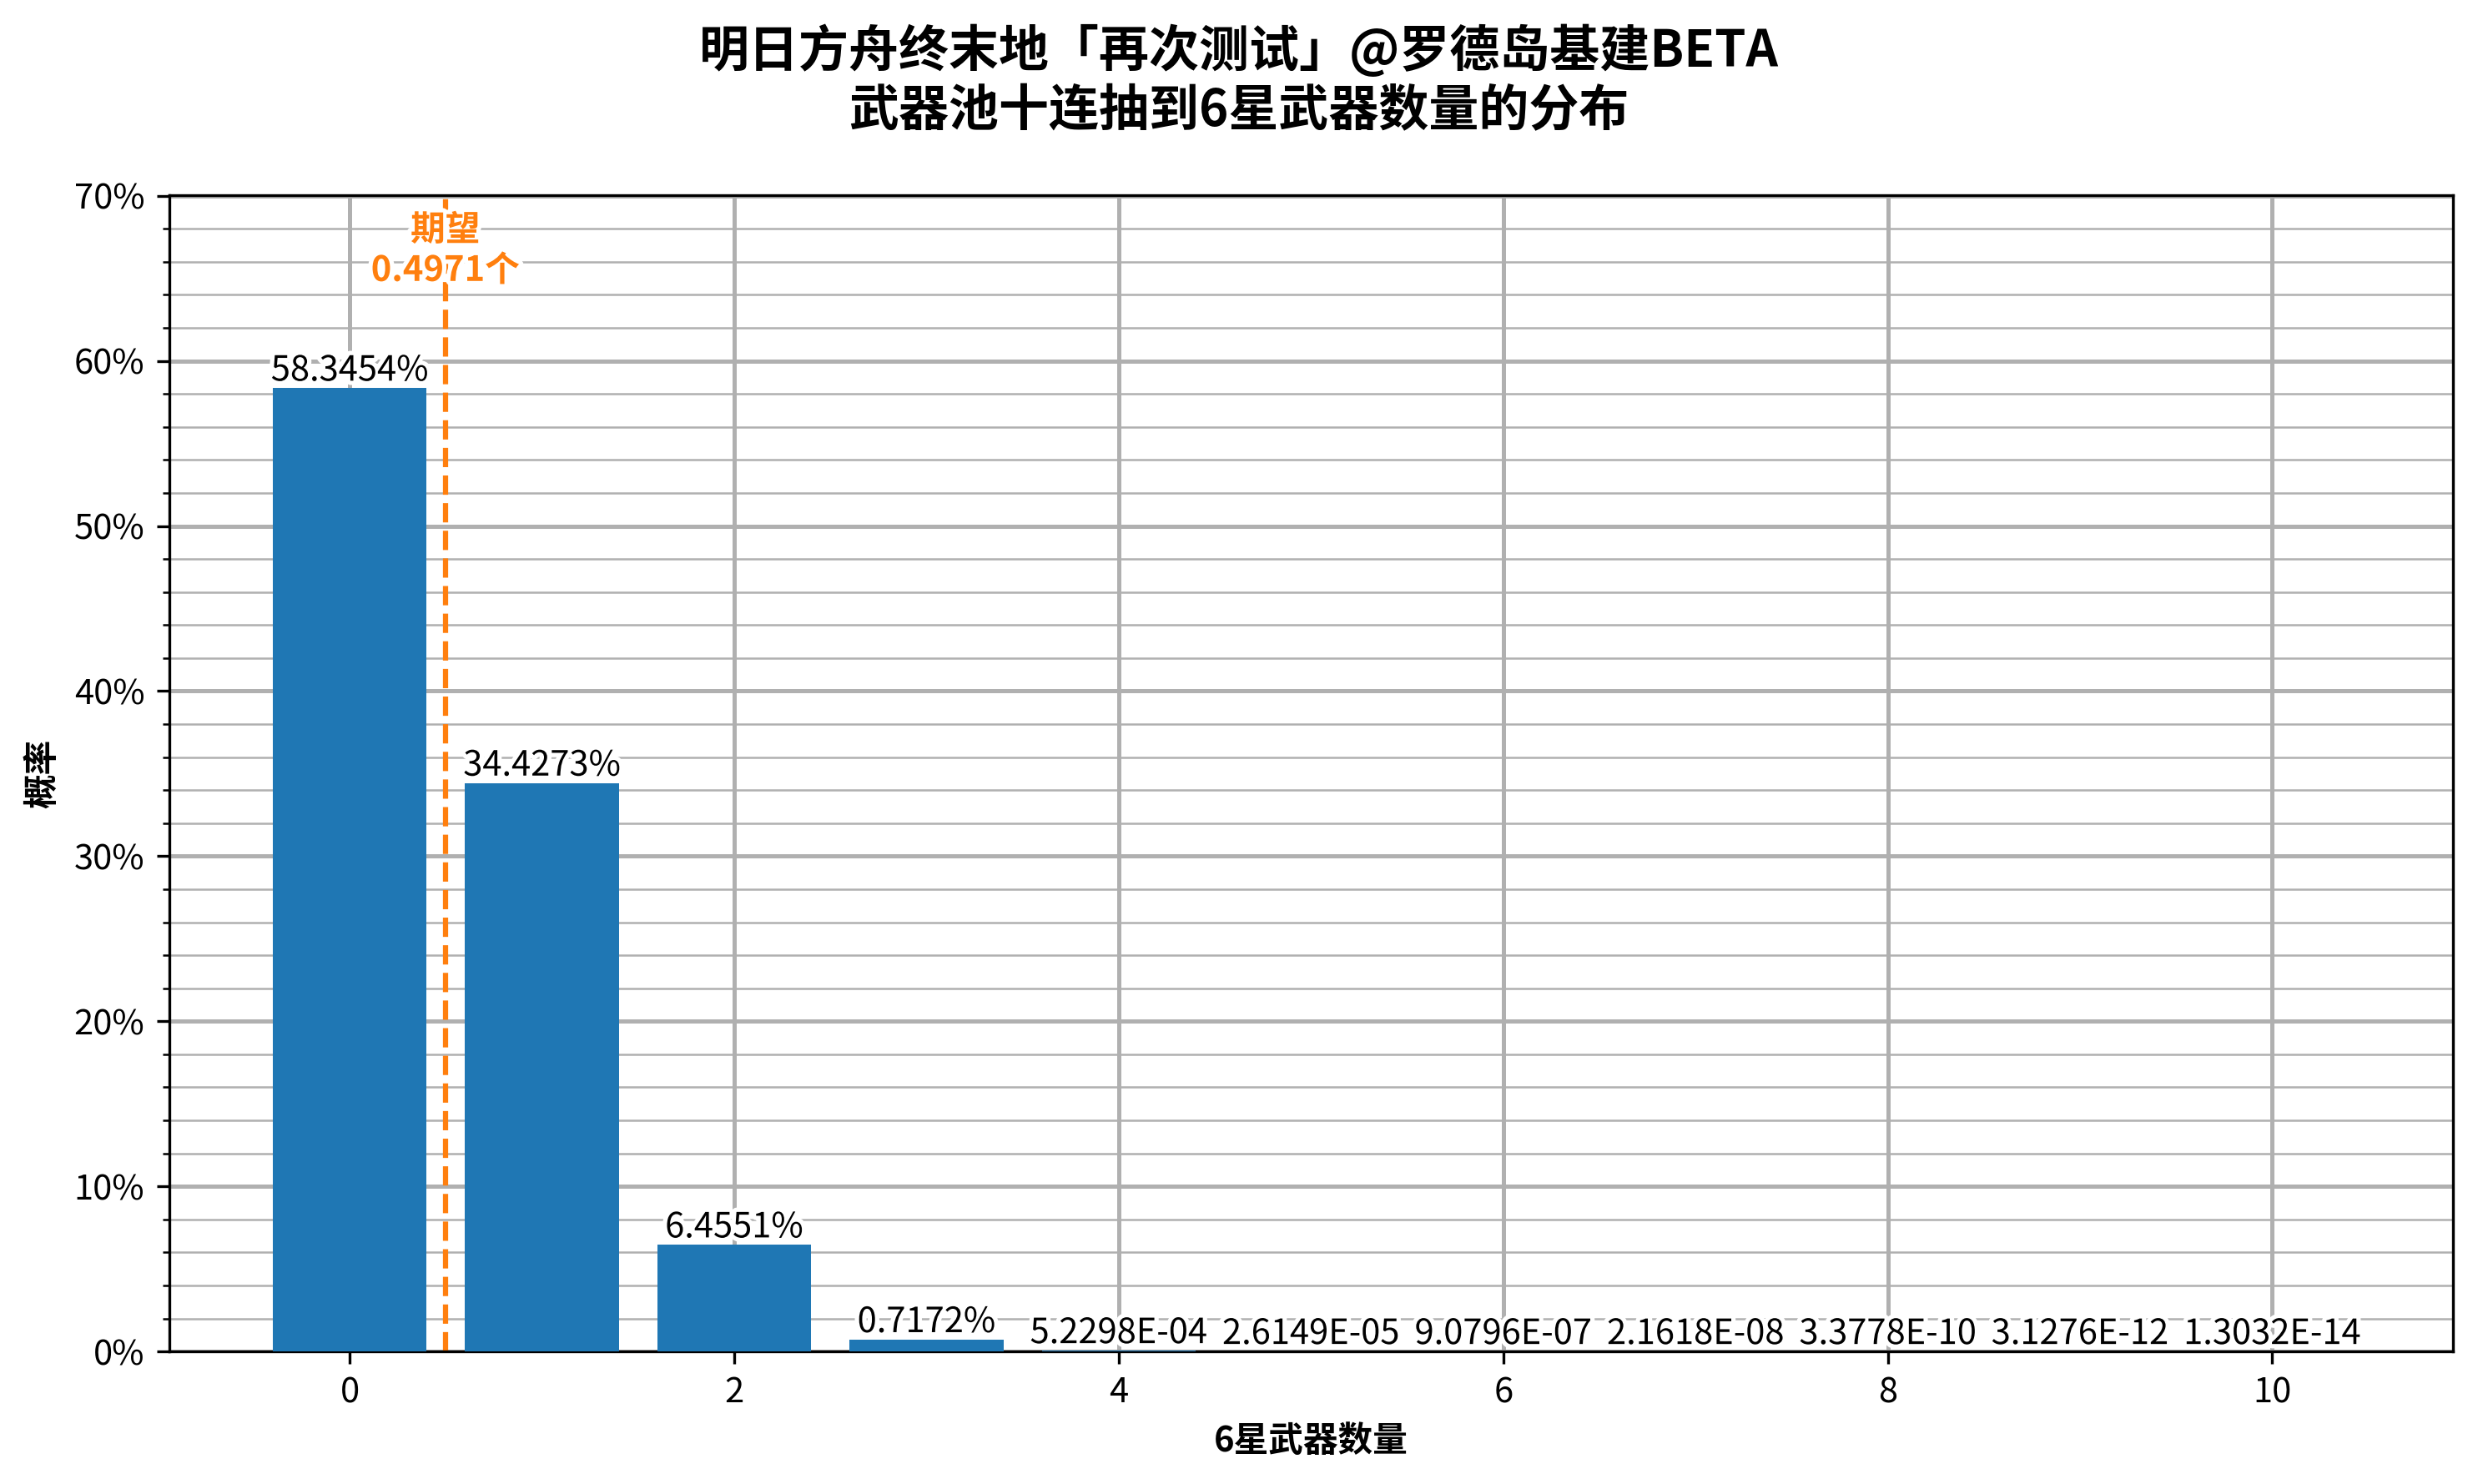

In [136]:
fig = plt.figure(figsize=(10, 6), layout="tight", dpi=300)
ax1 = fig.subplots(1, 1)

ax1.bar(range(11), 抽到n个6星的概率, zorder=10)
ax1_y_top = np.max(抽到n个6星的概率) * 1.2

# 图表标题、坐标轴标签
fig.suptitle(f"明日方舟终末地「再次测试」@罗德岛基建BETA\n武器池十连抽到6星武器数量的分布", fontweight="bold", fontsize="x-large")
# ax1.set_title("抽到UP6星干员时，获得的其他6星干员数量的边际分布", fontweight="bold")
ax1.set_ylabel("概率", fontweight="bold")
ax1.set_xlabel("6星武器数量", fontweight="bold")

# 显示概率具体数值
for i, p in enumerate(抽到n个6星的概率):
    ax1.annotate(f"{p:.4%}" if p >= 1e-3 else f"{p:.4E}", (i, p), textcoords="offset points", xytext=(0, 0), ha="center", va="bottom", path_effects=stroke_white)

# 期望值
ax1.axvline(抽到6星数量的期望, color="C1", linestyle="--")
ax1.annotate(f"期望\n{抽到6星数量的期望:.4f}个", (抽到6星数量的期望, ax1_y_top),
             ha="center", va="top", xytext=(0, -5), textcoords="offset points",
             color="C1", fontweight="bold", path_effects=stroke_white)


# 显示网格
ax1.yaxis.minorticks_on()
ax1.grid(True, which="major", linewidth=1.2)
ax1.yaxis.grid(True, which="minor", linewidth=0.6)

# y 轴标签显示为百分比
ax1.yaxis.set_major_formatter(PercentFormatter(1))

ax1.set_ylim(0, ax1_y_top)

fig.savefig(f"图片/武器池十连抽到6星武器数量的分布.png", dpi=300)


In [137]:
# 干员池十连6星数量分布

rv = scipy.stats.binom(10, 0.008)
x = np.arange(0, 11)
y = rv.pmf(x)

print('十连6*数量分布')
print('6*数量\t概率')
for i in range(11):
    print(f'{i}\t{y[i]}\t{1/y[i]}')


十连6*数量分布
6*数量	概率
0	0.9228194119572631	1.0836356355779728
1	0.07442092031913411	13.437081881166867
2	0.0027007592051298632	370.266256281043
3	5.808084312107238e-05	17217.380917068484
4	8.196893182409416e-07	1219974.419266566
5	7.932477273299435e-09	126064023.3242118
6	5.330965909475423e-11	18758326670.64273
7	2.4566663177306115e-13	4070556887529.469
8	7.429434428620798e-16	1345997477476411.5
9	1.3314398617599998e-18	7.510665924318377e+17
10	1.0737418239999999e-21	9.313225746154787e+20


In [138]:
# 武器池十连6星数量分布

rv = scipy.stats.binom(10, 0.04)
x = np.arange(0, 11)
y = rv.pmf(x)

print('十连6*数量分布')
print('6*数量\t概率')
for i in range(11):
    print(f'{i}\t{y[i]}\t{1/y[i]}')


十连6*数量分布
6*数量	概率
0	0.6648326359915008	1.5041379527174474
1	0.277013598329792	3.609931086521874
2	0.05194004968683601	19.252965794783325
3	0.005771116631870671	173.27669215304982
4	0.00042081058774056957	2376.3660638132556
5	2.1040529387028485e-05	47527.3212762651
6	7.305739370496003e-07	1368786.8527564346
7	1.73946175488e-08	57489047.815770276
8	2.717908992000002e-10	3679299060.209295
9	2.516582400000001e-12	397364298502.604
10	1.0485760000000001e-14	95367431640624.98
